AGN selections

In [1]:
import pandas as pd
import numpy as np
# import itertools as it

import pickle as pcl

from scipy.spatial.distance import cdist
from scipy.stats import binned_statistic

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

In [2]:
from palettable.tableau import GreenOrange_12

cmap = GreenOrange_12.hex_colors

In [3]:
import hightolowz

In [198]:
redshifts = ['2p07','3p10','3p95','5p03']#,'6p42']
zees = [2.07,3.10,3.95,5.03]#,'6p42']

In [126]:
selection = 'mstar'

gals = [None] * 5

for i, redshift in enumerate(redshifts):

    gals[i] = pd.read_csv('data/henriques2015a_z%s_mstar.csv' % redshift, skiprows=104, skipfooter=1, engine='python')

    gals[i] = pd.concat([gals[i], pd.read_csv('data/planck1/dgal_%s_%s_r5_gals.csv' % (selection, redshift))], axis=1)
    gals[i] = pd.concat([gals[i], pd.read_csv('data/planck1/dgal_%s_%s_r7.5_gals.csv' % (selection, redshift))], axis=1)
    gals[i] = pd.concat([gals[i], pd.read_csv('data/planck1/dgal_%s_%s_r12.5_gals.csv' % (selection, redshift))], axis=1)
    gals[i] = pd.concat([gals[i], pd.read_csv('data/planck1/dgal_%s_%s_r20_gals.csv' % (selection, redshift))], axis=1)

In [49]:
sum(gals['zn_xrayLum'] > 46)

4924

In [72]:
epsilon = 0.1
c = 2.97 * 10**8 # m s^-1
G = 6.67 * 10**-11 # m^3 kg^-1 s^-2
mp = 1.67 * 10**-27 # kg
sigmaT = 6.65 * 10**-29 # 

Medd = (4. * np.pi * G * gals['zn_blackHoleMass'] * 1e10 * mp) / (epsilon * c * sigmaT)  # Msol s^-1
mdot = gals['zn_quasarAccretionRate'] / (365.25*24*60*60) / Medd  
# mdot = gals['zn_radioAccretionRate'] / (365.25*24*60*60) / Medd

print sum(mdot >= 0.01), sum(mdot < 0.01), len(mdot)

46157 109195 875643


In [73]:
Lbol = np.array([None] * len(mdot))

mask = np.array(mdot >= 0.01)
Lbol[mask] = epsilon * (gals['zn_quasarAccretionRate'][mask] * 1.989 * 10**30 / (365.25*24*60*60)) * c**2  # J s^-1
Lbol[mask] /= 1e-7 # erg s^-1

In [80]:
mask = np.array(mdot < 0.01)
Lbol[mask] = 0.44 * (mdot[mask] / 0.01) * epsilon * (gals['zn_quasarAccretionRate'][mask] * 1.989 * 10**30 / (365.25*24*60*60)) * c**2 # J s^-1
Lbol[mask] /= 1e-7 # erg s^-1

In [271]:
print sum(Lbol > 10**44)

4591


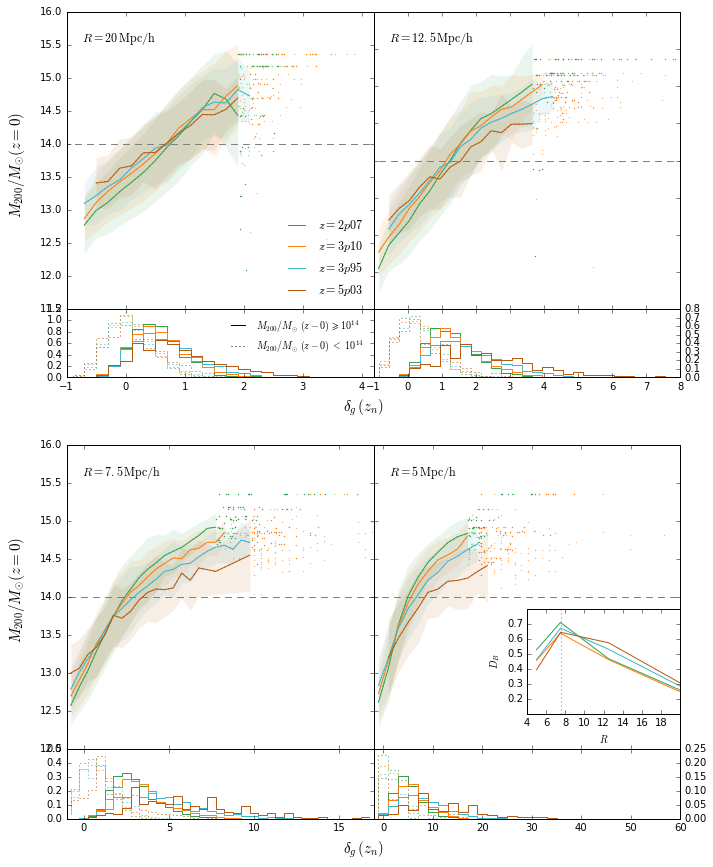

In [315]:
quasar_lim = 0.01

fig = plt.figure(figsize=(11,11.8))

gs1 = gridspec.GridSpec(32, 16)

gs1.update(bottom = 0.57, top = 1, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs1[0:26,0:8])
ax2 = fig.add_subplot(gs1[0:26,8:16])

ax5 = fig.add_subplot(gs1[26:32,0:8])
ax6 = fig.add_subplot(gs1[26:32,8:16])


gs2 = gridspec.GridSpec(32, 16)

gs2.update(top=0.49, bottom=0.05, hspace=0, wspace=0)

ax3 = fig.add_subplot(gs2[0:26,0:8])
ax4 = fig.add_subplot(gs2[0:26,8:16])

ax7 = fig.add_subplot(gs2[26:32,0:8])
ax8 = fig.add_subplot(gs2[26:32,8:16])

ax9 = fig.add_subplot(gs2[14:23,12:16])

Bhatta =[[] for i in range(len(redshifts))]

## Subplots
BinLimits = [np.linspace(-1, 4.2, 27), np.linspace(-1, 8, 31), np.linspace(-1, 17, 37), np.linspace(-2, 60, 32)]
Bins = [np.linspace(-0.9, 4.1, 26), np.linspace(-0.85, 7.85, 30), np.linspace(-0.75, 16.75, 36), np.linspace(-1, 59, 31)]

for i, redshift in enumerate(redshifts):
    
    mask = ~np.isnan(np.log10(gals[i][gals[i]['zn_quasarAccretionRate'] > quasar_lim]['z0_central_mcrit200'] * 1e10))
    
    for axt, axb, R, binLimits, bins in zip([ax1,ax2,ax3,ax4], [ax5,ax6,ax7,ax8], 
                                            ['20','12.5','7.5','5'], BinLimits, Bins):
        
        # Subplot
        phiB, mass = np.histogram(gals[i][(gals[i]['zn_quasarAccretionRate'] > quasar_lim) & \
                                           (gals[i]['z0_central_mcrit200'] < 1e4)]['delta_gal_%s'%R],
                                     bins=binLimits, normed=True)
        
        
        phiA, mass = np.histogram(gals[i][(gals[i]['zn_quasarAccretionRate'] > quasar_lim) & \
                                       (gals[i]['z0_central_mcrit200'] >= 1e4)]['delta_gal_%s'%R],
                                 bins=binLimits, normed=True)
        
        DB, BC = hightolowz.bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))
        
        Bhatta[i].append(DB)
        
        axb.set_xlim(binLimits[0], binLimits[-1])
        axt.set_xlim(binLimits[0], binLimits[-1])

        # Main Plot
        median = binned_statistic(gals[i][gals[i]['zn_quasarAccretionRate'] > quasar_lim]['delta_gal_%s'%R][mask], 
                          np.log10(gals[i][gals[i]['zn_quasarAccretionRate'] > quasar_lim]['z0_central_mcrit200'] * 1e10)[mask],
                          bins=binLimits, statistic='median')[0]

        count = binned_statistic(gals[i][gals[i]['zn_quasarAccretionRate'] > quasar_lim]['delta_gal_%s'%R][mask], 
                                  np.log10(gals[i][gals[i]['zn_quasarAccretionRate'] > quasar_lim]['z0_central_mcrit200'] * 1e10)[mask],
                                  bins=binLimits, statistic='count')[0]

        std = binned_statistic(gals[i][gals[i]['zn_quasarAccretionRate'] > quasar_lim]['delta_gal_%s'%R][mask], 
                                 np.log10(gals[i][gals[i]['zn_quasarAccretionRate'] > quasar_lim]['z0_central_mcrit200'] * 1e10)[mask],
                                 bins=binLimits, statistic='std')[0]

        cmask = (count > 20)
        axt.fill_between(bins[cmask], median[cmask]+std[cmask], median[cmask]-std[cmask], 
                         alpha=0.1, linewidth=0, color=cmap[i*2])
        
        axt.plot(bins[cmask], median[cmask], color=cmap[i*2], label='$z = %s$'%redshift)
        
        axt.scatter(gals[i][(gals[i]['zn_quasarAccretionRate'] > quasar_lim) & (gals[i]['delta_gal_%s'%R] > max(bins[cmask]))]['delta_gal_%s'%R],
            np.log10(gals[i][(gals[i]['zn_quasarAccretionRate'] > quasar_lim) & (gals[i]['delta_gal_%s'%R] > max(bins[cmask]))]['z0_central_mcrit200'] * 1e10),
            marker='.', s=8, c=cmap[i], lw=0, label=None)

        axt.plot(bins[cmask], median[cmask], color=cmap[i*2], linestyle='dotted')

        axt.hlines(14, -10, 60, linestyle='--', color='grey')
        
        axt.set_xticklabels([])

        axb.step(bins, phiA, color=cmap[i*2], alpha=1)# + i*0.1)
        axb.step(bins, phiB, color=cmap[i*2], linestyle='dotted', alpha=1)# + i*0.1)

        phi, mass = np.histogram(gals[i]['delta_gal_%s'%R], bins=binLimits, normed=True)

        if(i==0):
            axt.text(0.05, 0.9, '$R = %s \, \mathrm{Mpc / h}$'%R, transform=axt.transAxes, size=12)
            


for i,z in enumerate(redshifts):
    ax9.plot([20,12.5,7.5,5], Bhatta[i], color=cmap[i*2])
    
ax9.set_xlabel('$R$')
ax9.set_ylabel('$D_{B}$')
ax9.set_xticklabels([4,6,8,10,12,14,16,18,''])
ax9.set_yticklabels(['',0.2,0.3,0.4,0.5,0.6,0.7,''])
ax9.vlines(7.5, 0, 0.7, colors='grey', linestyles='dotted')

## Legend
line1 = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
line2 = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted')

ax5.legend(handles=[line1, line2], 
           labels=['$M_{200} / M_{\odot} \; (z-0) \; \geqslant \; 10^{14}$',
                   '$M_{200} / M_{\odot} \; (z-0) \; < \; 10^{14}$'], 
           loc=1, prop={'size':10}, frameon=False)

ax1.legend(loc=4, frameon=False)

ax2.set_yticklabels([])
ax4.set_yticklabels([])

ax6.yaxis.tick_right()
ax8.yaxis.tick_right()

fig.text(0.5, 0.53, '$\delta_{g}\,(z_{n})$', size=15, ha='center')  # common X 1
fig.text(0.5, 0.01, '$\delta_{g}\,(z_{n})$', size=15, ha='center')  # common X 2
fig.text(0.05, 0.82, '$M_{200} / M_{\odot} (z = 0)$', va='center', size = 15, rotation='vertical')  # common Y 1
fig.text(0.05, 0.32, '$M_{200} / M_{\odot} (z = 0)$', va='center', size = 15, rotation='vertical')  # common Y 2

# plt.savefig('../papers/hightolowz/images/quasar_select.png', bbox_inches='tight', dpi=300)


In [29]:
radio_lim = 0.0005

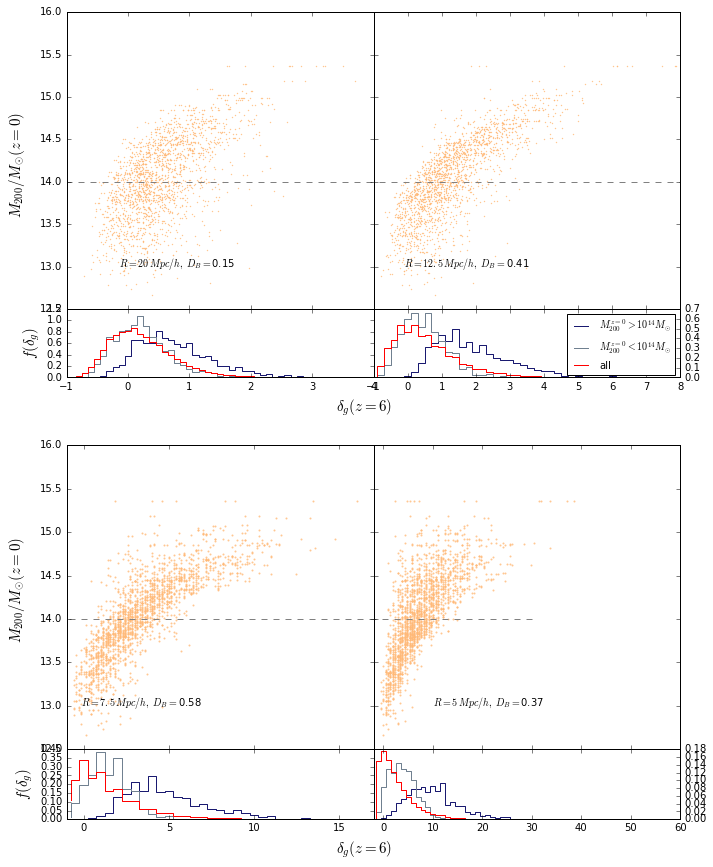

In [30]:
fig = plt.figure(figsize=(11,11.8))

gs1 = gridspec.GridSpec(16, 2)

gs1.update(bottom = 0.57, top = 1, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs1[0:13,0])
ax2 = fig.add_subplot(gs1[0:13,1])

ax5 = fig.add_subplot(gs1[13:16,0])
ax6 = fig.add_subplot(gs1[13:16,1])


gs2 = gridspec.GridSpec(16, 2)

gs2.update(top=0.49, bottom=0.05, hspace=0, wspace=0)

ax3 = fig.add_subplot(gs2[0:13,0])
ax4 = fig.add_subplot(gs2[0:13,1])

ax7 = fig.add_subplot(gs2[13:16,0])
ax8 = fig.add_subplot(gs2[13:16,1])




## Subplot 1
binLimits = np.linspace(-1, 4, 51)
bins = np.linspace(-0.95, 3.95, 50)

phiA, mass = np.histogram(gals[(gals['zn_radioAccretionRate'] > radio_lim) & \
                               (gals['z0_central_mcrit200'] >= 1e4)]['delta_gal_20'],
                         bins=binLimits, normed=True)

ax5.step(bins, phiA, label='$M_{200}^{z=0} > 10^{14} M_{\odot}$', color='midnightblue')

phiB, mass = np.histogram(gals[(gals['zn_radioAccretionRate'] > radio_lim) & \
                               (gals['z0_central_mcrit200'] < 1e4)]['delta_gal_20'],
                         bins=binLimits, normed=True)

ax5.step(bins, phiB, label='$M_{200}^{z=0} < 10^{14} M_{\odot}$', color='slategrey')

phi, mass = np.histogram(gals['delta_gal_20'], bins=binLimits, normed=True)
ax5.step(bins, phi, label='all', color='red')

DB, BC = hightolowz.bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))

#ax5.legend(loc=2)
ax5.set_xlim(binLimits[0], binLimits[-1])
ax5.set_ylabel('$f(\delta_{g})$', size = 15)

## Plot 1
ax1.scatter(gals[gals['zn_radioAccretionRate'] > radio_lim]['delta_gal_20'],
            np.log10(gals[gals['zn_radioAccretionRate'] > radio_lim]['z0_central_mcrit200'] * 1e10),
            marker='.', s=8, alpha=0.8, c=cmap[3], lw=0, label='$z = 6$')

#ax1.set_yscale('log')

#ax1.set_ylim(2e12, 3e15)
ax1.set_xlim(binLimits[0], binLimits[-1])
ax1.set_xticklabels([])
#ax1.legend(loc=2, scatterpoints=1, numpoints=1, prop={'size': 10})
ax1.text(-0.14, 13, '$R = 20 \, Mpc / h, \; D_{B} = $' + str(round(DB, 2)))



## Subplot 2
binLimits = np.linspace(-1, 8, 46)
bins = np.linspace(-0.9, 7.9, 45)

phiA, mass = np.histogram(gals[(gals['zn_radioAccretionRate'] > radio_lim) & \
                               (gals['z0_central_mcrit200'] >= 1e4)]['delta_gal_12.5'],
                         bins=binLimits, normed=True)

ax6.step(bins, phiA, label='$M_{200}^{z=0} > 10^{14} M_{\odot}$', color='midnightblue')


phiB, mass = np.histogram(gals[(gals['zn_radioAccretionRate'] > radio_lim) & \
                               (gals['z0_central_mcrit200'] < 1e4)]['delta_gal_12.5'],
                         bins=binLimits, normed=True)

ax6.step(bins, phiB, label='$M_{200}^{z=0} < 10^{14} M_{\odot}$', color='slategrey')

phi, mass = np.histogram(gals['delta_gal_12.5'], bins=binLimits, normed=True)
ax6.step(bins, phi, label='all', color='red')

DB, BC = hightolowz.bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))

ax6.legend(loc=1, prop={'size': 10})
ax6.set_xlim(binLimits[0], binLimits[-1])
#ax6.set_ylim(0, 4.45)
ax6.yaxis.tick_right()


## Plot 2
                               
ax2.scatter(gals[gals['zn_radioAccretionRate'] > radio_lim]['delta_gal_12.5'],
            np.log10(gals[gals['zn_radioAccretionRate'] > radio_lim]['z0_central_mcrit200'] * 1e10),
            marker='.', s=8, alpha=0.8, c=cmap[3], lw=0, label='$z = 6$')

#ax2.set_yscale('log')

#ax2.set_ylim(2e12, 3e15)
ax2.set_xlim(binLimits[0], binLimits[-1])
ax2.text(-0.12, 13, '$R = 12.5 \, Mpc / h, \; D_{B} = $' + str(round(DB, 2)))
ax2.set_yticklabels([])
ax2.set_xticklabels([])


## Subplot 3
binLimits = np.linspace(-1, 17, 37)
bins = np.linspace(-0.75, 16.75, 36)

phiA, mass = np.histogram(gals[(gals['zn_radioAccretionRate'] > radio_lim) & \
                               (gals['z0_central_mcrit200'] >= 1e4)]['delta_gal_7.5'],
                         bins=binLimits, normed=True)

ax7.step(bins, phiA, label='$M_{200}^{z=0} > 10^{14} M_{\odot}$', color='midnightblue')


phiB, mass = np.histogram(gals[(gals['zn_radioAccretionRate'] > radio_lim) & \
                               (gals['z0_central_mcrit200'] < 1e4)]['delta_gal_7.5'],
                         bins=binLimits, normed=True)

ax7.step(bins, phiB, label='$M_{200}^{z=0} < 10^{14} M_{\odot}$', color='slategrey')

phi, mass = np.histogram(gals['delta_gal_7.5'],bins=binLimits, normed=True)
ax7.step(bins, phi, label='all', color='red')

DB, BC = hightolowz.bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))

ax7.set_xlim(binLimits[0], binLimits[-1])
#ax7.set_xlim(-0.2, 2.45)
ax7.set_ylabel('$f(\delta_{g})$', size = 15)


## Plot 3
ax3.scatter(gals[gals['zn_radioAccretionRate'] > radio_lim]['delta_gal_7.5'],
            np.log10(gals[gals['zn_radioAccretionRate'] > radio_lim]['z0_central_mcrit200'] * 1e10),
            marker='o', s=4, alpha=0.8, c=cmap[3], 
            lw=0, label='z6 selected')#, c=np.log10(dat_z6top_go['z6_m_crit200']), cmap='viridis')

#ax3.set_yscale('log')

#ax3.set_ylim(2e12, 3e15)
ax3.set_xlim(binLimits[0], binLimits[-1])
ax3.text(-0.13, 13, '$R = 7.5 \, Mpc / h, \; D_{B} = $' + str(round(DB, 2)))
ax3.set_xticklabels([])



## Subplot 4
binLimits = np.linspace(-2, 60, 63)
bins = np.linspace(-1.5, 59.5, 62)

phiA, mass = np.histogram(gals[(gals['zn_radioAccretionRate'] > radio_lim) & \
                               (gals['z0_central_mcrit200'] >= 1e4)]['delta_gal_5'],
                         bins=binLimits, normed=True)

ax8.step(bins, phiA, label='$M_{200}^{z=0} > 10^{14} M_{\odot}$', color='midnightblue')


phiB, mass = np.histogram(gals[(gals['zn_radioAccretionRate'] > radio_lim) & \
                               (gals['z0_central_mcrit200'] < 1e4)]['delta_gal_5'],
                         bins=binLimits, normed=True)

ax8.step(bins, phiB, label='$M_{200}^{z=0} < 10^{14} M_{\odot}$', color='slategrey')

phi, mass = np.histogram(gals['delta_gal_5'], bins=binLimits, normed=True)
ax8.step(bins, phi, label='all', color='red')

DB, BC = hightolowz.bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))

ax8.yaxis.tick_right()
ax8.set_xlim(binLimits[0], binLimits[-1])
#ax8.set_ylim(0, 1)

## Plot 4
ax4.scatter(gals[gals['zn_radioAccretionRate'] > radio_lim]['delta_gal_5'],
            np.log10(gals[gals['zn_radioAccretionRate'] > radio_lim]['z0_central_mcrit200'] * 1e10), 
            marker='o', s=4, alpha=0.8, c=cmap[3], 
            lw=0, label='$z = 6$')#, c=np.log10(dat_z6top_go['z6_m_crit200']), cmap='viridis')

#ax4.set_ylim(2e12, 3e15)
ax4.set_xlim(binLimits[0], binLimits[-1])
ax4.text(10, 13, '$R = 5 \, Mpc / h, \; D_{B} = $' + str(round(DB, 2)))
ax4.set_yticklabels([])
ax4.set_xticklabels([])



for ax in [ax1,ax2,ax3,ax4]:
    ax.hlines(14, -10, 30, linestyle='--', color='grey')

fig.text(0.5, 0.53, '$\delta_{g} (z = 6)$', size=15, ha='center')  # common X 1
fig.text(0.5, 0.01, '$\delta_{g} (z = 6)$', size=15, ha='center')  # common X 2
fig.text(0.05, 0.82, '$M_{200} / M_{\odot} (z = 0)$', va='center', size = 15, rotation='vertical')  # common Y 1
fig.text(0.05, 0.32, '$M_{200} / M_{\odot} (z = 0)$', va='center', size = 15, rotation='vertical')  # common Y 2

#plt.savefig('../papers/hightolowz/images/radio_select.png', bbox_inches='tight', dpi=300)